In [1]:
import os
import pickle

import pandas as pd
import numpy as np
import researchpy as rp
import scipy.stats as stats
from sklearn.cluster import DBSCAN

import geopandas as gpd

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go

import matplotlib as mpl

import warnings
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 1000)
pd.options.display.max_rows = 4000
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

## Import local class
from apply_brf import SplitTrainAndPredict

In [2]:
## Define your path
PATH = r"D:\francisco_madrigal\Desktop\Tesis\modelo"

def create_path(file_path, path=PATH):
    
    return os.path.join(path, file_path)

In [3]:
## Open dictionary of crimes
crime_cat_file = open(create_path("crime_cat_dict.pkl"), "rb")
crime_cat_dict = pickle.load(crime_cat_file)

In [4]:
## Read neighborhoods DataFrame for later use
colonias = gpd.read_file(create_path(r"colonias_fixed\colonias_fixed.shp"))

## Declare the used coordinate system
colonias.crs = "epsg:4326"

## Print Coordinate Reference System (CRS)
# This is importan to homologue all crs from other georeferenced DataFrames
colonias.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Ver https://imbalanced-learn.org/stable/index.html

## Data Transformation

In [5]:
## Read DataFrame
matrix_crimes = pd.read_csv(create_path("base_crimenes.csv"),
                            parse_dates =['Hora'])       

## Show the balance of crimes DataFrame
matrix_crimes.value_counts(subset=["crimen"], normalize=True).to_frame('Relative').merge(
    
    matrix_crimes.value_counts(subset=["crimen"]).to_frame('Absolute'),
    on='crimen')

,Relative,Absolute
crimen,,
0,0.985901,13576405
1,0.014099,194150


In [6]:
## Merge to locate the Municipality for each nieghborhood
matrix_crimes = matrix_crimes.merge(colonias[['id_colonia', 'alcaldi']],
                                   how='left',
                                   on='id_colonia')

## Create an empty DataFrame to save the predictions for each municipality
results_brf = pd.DataFrame({})

## Create an empty DataFrame to save all scores of applied models
all_scores = pd.DataFrame({})

## Create an empty DataFrame to save tran-test-split results
train_test_table = pd.DataFrame({})

In [7]:
## Based on feature selection with Lasso Regression, drop features that were shrunk to zero
matrix_crimes = matrix_crimes.drop(['pop_per_km2','pay_day'], 
                               axis = 1)

In [8]:
matrix_crimes.head(5)

,Hora,id_colonia,day_period,day,month,year,Coordinates,categoria_delito,crimen,dia_semana,indice,past_near_crimes_500mts,no_labor_day,past_crimes,TEMP,PRCP,CO,O3,PM10,covid_dummy,area_km2,metro,metrobus,rtp,supers_minisupers,department_stores,banks,corporate_offices,restaurants,g_edu,no_healt_s,house_per_km2,alcaldi
0,2017-01-16 00:00:00,1,0,16,1,2017,NaN,NaN,0,0,61,0,0,0.0,59.45,0.0,0.890902,36.186235,48.605324,0,3.128549,0,0,38,67.0,22.0,186.0,29.0,169.0,13.599699,0.134291,850.23446,MIGUEL HIDALGO
1,2017-01-16 06:00:00,1,1,16,1,2017,NaN,NaN,0,0,62,0,0,0.0,59.45,0.0,0.890902,36.186235,48.605324,0,3.128549,0,0,38,67.0,22.0,186.0,29.0,169.0,13.599699,0.134291,850.23446,MIGUEL HIDALGO
2,2017-01-16 12:00:00,1,2,16,1,2017,NaN,NaN,0,0,63,0,0,0.0,59.45,0.0,0.890902,36.186235,48.605324,0,3.128549,0,0,38,67.0,22.0,186.0,29.0,169.0,13.599699,0.134291,850.23446,MIGUEL HIDALGO
3,2017-01-16 18:00:00,1,3,16,1,2017,NaN,NaN,0,0,64,0,0,0.0,59.45,0.0,0.890902,36.186235,48.605324,0,3.128549,0,0,38,67.0,22.0,186.0,29.0,169.0,13.599699,0.134291,850.23446,MIGUEL HIDALGO
4,2017-01-17 00:00:00,1,0,17,1,2017,NaN,NaN,0,1,65,1,0,0.0,60.65,0.0,0.760863,35.344061,45.331019,0,3.128549,0,0,38,67.0,22.0,186.0,29.0,169.0,13.599699,0.134291,850.23446,MIGUEL HIDALGO


### Apply Balanced Random Forest

----------------------------------------------------------------------------------------------------
|MIGUEL HIDALGO|


Total features:  44
Observations:  637825


***TRAIN TABLE***
   Relative  Absolute
0  0.979132    624515
1  0.020868     13310


***TEST TABLE***
   Relative  Absolute
0  0.988386     31317
1  0.011614       368
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: sqrt
   Threshold that max F1: 0.771



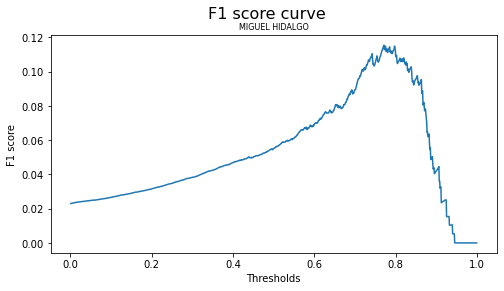

Results of Balanced Random Forest:

   F1 Score: 0.11541774332472006
   Accuracy: 0.9675871863657882
   Balanced Accuracy: 0.5794414601182022
   Average Precision Score: 0.046131142641628695


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     31317
           1       0.08      0.18      0.12       368

    accuracy                           0.97     31685
   macro avg       0.54      0.58      0.55     31685
weighted avg       0.98      0.97      0.97     31685

***************************


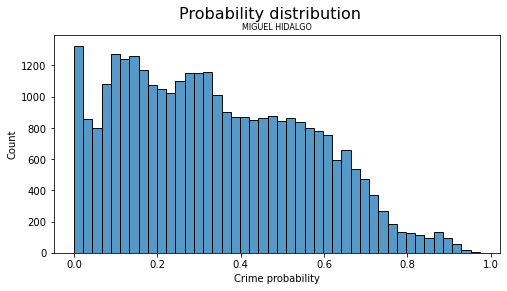

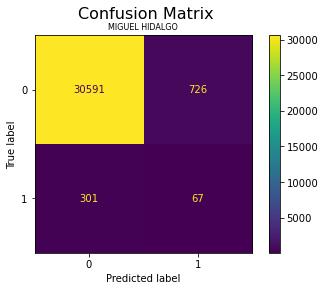

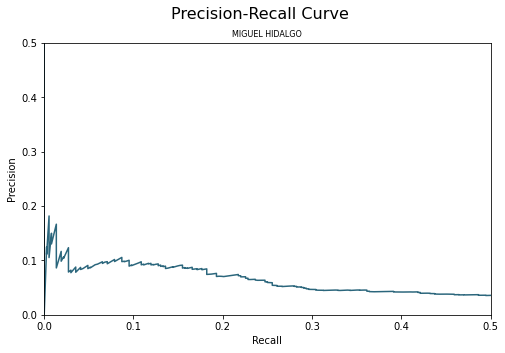

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|COYOACAN|


Total features:  44
Observations:  1115182


***TRAIN TABLE***
   Relative  Absolute
0  0.990592   1104690
1  0.009408     10492


***TEST TABLE***
   Relative  Absolute
0  0.993687     55091
1  0.006313       350
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: sqrt
   Threshold that max F1: 0.857



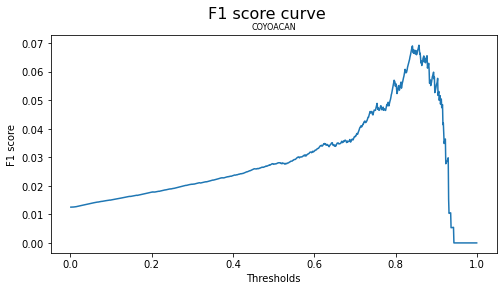

Results of Balanced Random Forest:

   F1 Score: 0.06932773109243698
   Accuracy: 0.9840190472754821
   Balanced Accuracy: 0.5419786742454692
   Average Precision Score: 0.023373332841379435


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     55091
           1       0.05      0.09      0.07       350

    accuracy                           0.98     55441
   macro avg       0.52      0.54      0.53     55441
weighted avg       0.99      0.98      0.99     55441

***************************


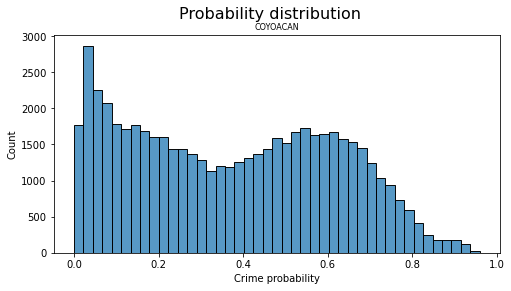

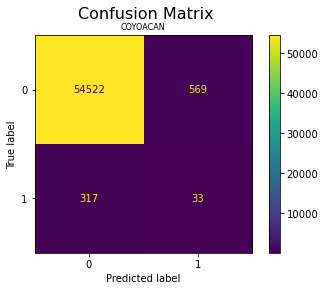

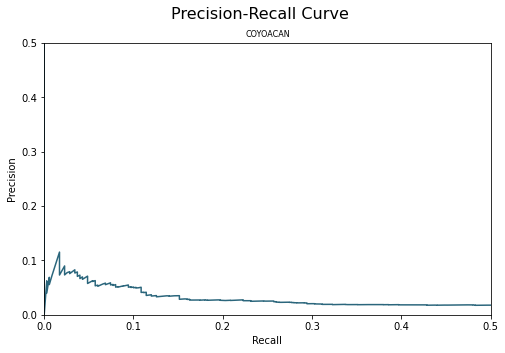

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|VENUSTIANO CARRANZA|


Total features:  44
Observations:  586864


***TRAIN TABLE***
   Relative  Absolute
0  0.979377    574761
1  0.020623     12103


***TEST TABLE***
   Relative  Absolute
0  0.986524     28771
1  0.013476       393
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: sqrt
   Threshold that max F1: 0.798



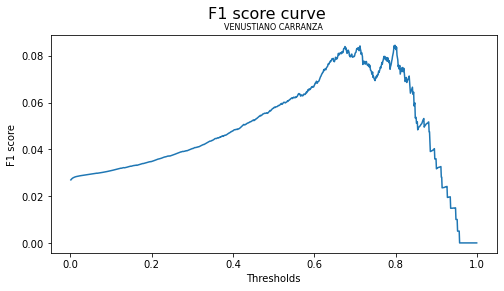

Results of Balanced Random Forest:

   F1 Score: 0.08447729672650475
   Accuracy: 0.9702715676861885
   Balanced Accuracy: 0.5419579794928859
   Average Precision Score: 0.046318594463390435


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     28771
           1       0.07      0.10      0.08       393

    accuracy                           0.97     29164
   macro avg       0.53      0.54      0.53     29164
weighted avg       0.98      0.97      0.97     29164

***************************


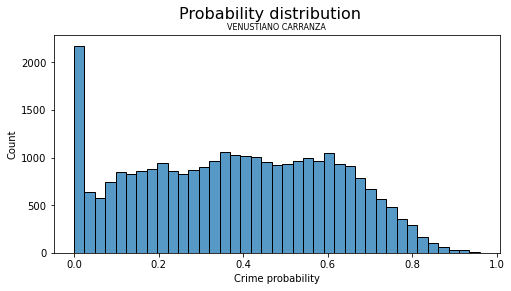

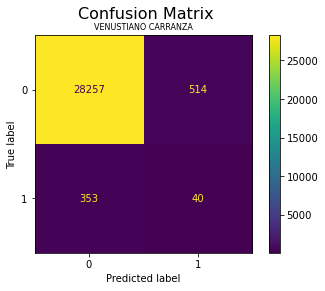

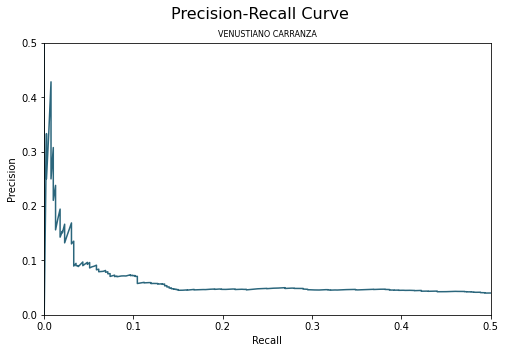

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|LA MAGDALENA CONTRERAS|


Total features:  44
Observations:  376495


***TRAIN TABLE***
   Relative  Absolute
0  0.994252    374331
1  0.005748      2164


***TEST TABLE***
   Relative  Absolute
0  0.994925     18625
1  0.005075        95
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: sqrt
   Threshold that max F1: 0.784



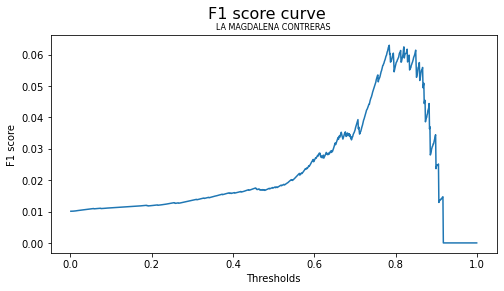

Results of Balanced Random Forest:

   F1 Score: 0.06301824212271974
   Accuracy: 0.9698183760683761
   Balanced Accuracy: 0.5868724832214766
   Average Precision Score: 0.01753194619016271


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     18625
           1       0.04      0.20      0.06        95

    accuracy                           0.97     18720
   macro avg       0.52      0.59      0.52     18720
weighted avg       0.99      0.97      0.98     18720

***************************


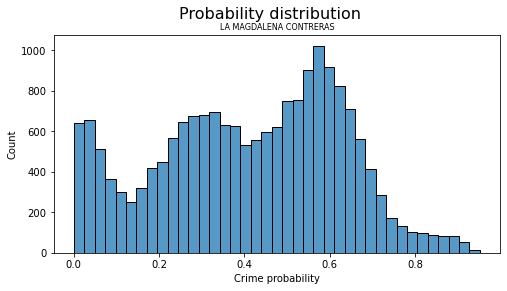

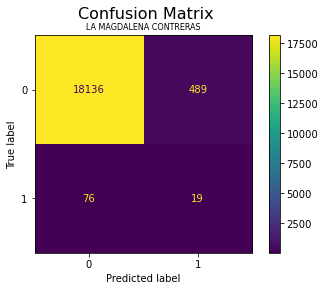

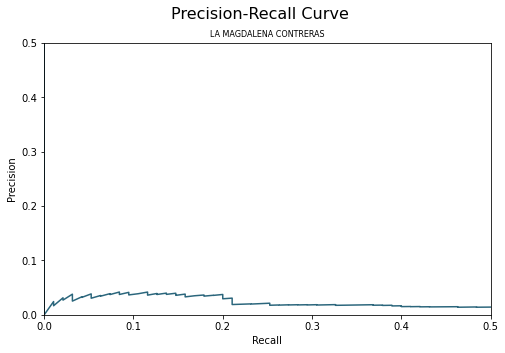

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|BENITO JUAREZ|


Total features:  44
Observations:  463677


***TRAIN TABLE***
   Relative  Absolute
0   0.97583    452470
1   0.02417     11207


***TEST TABLE***
   Relative  Absolute
0  0.985724     22716
1  0.014276       329
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: sqrt
   Threshold that max F1: 0.642



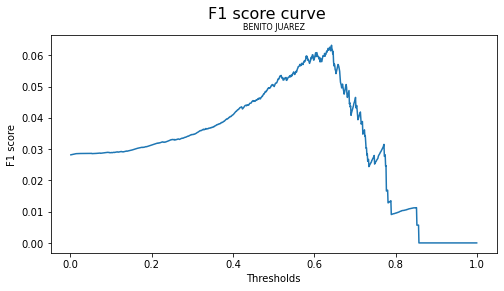

Results of Balanced Random Forest:

   F1 Score: 0.06318812829104835
   Accuracy: 0.9150791928834888
   Balanced Accuracy: 0.563017457266707
   Average Precision Score: 0.027332753014377265


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     22716
           1       0.04      0.20      0.06       329

    accuracy                           0.92     23045
   macro avg       0.51      0.56      0.51     23045
weighted avg       0.97      0.92      0.94     23045

***************************


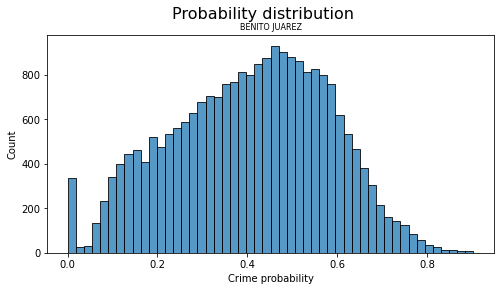

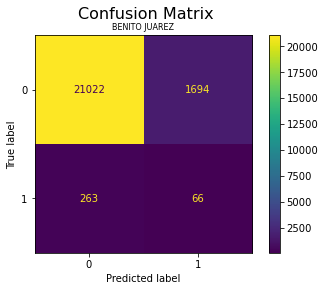

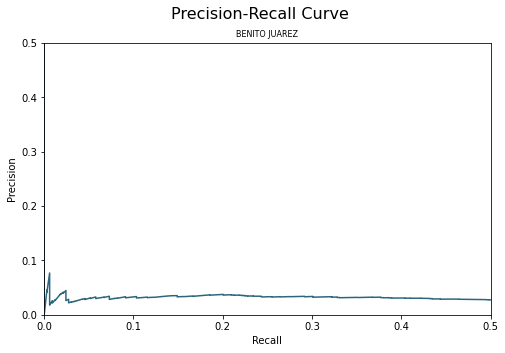

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|GUSTAVO A. MADERO|


Total features:  44
Observations:  1680123


***TRAIN TABLE***
   Relative  Absolute
0  0.987139   1658515
1  0.012861     21608


***TEST TABLE***
   Relative  Absolute
0  0.992051     82866
1  0.007949       664
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: sqrt
   Threshold that max F1: 0.807



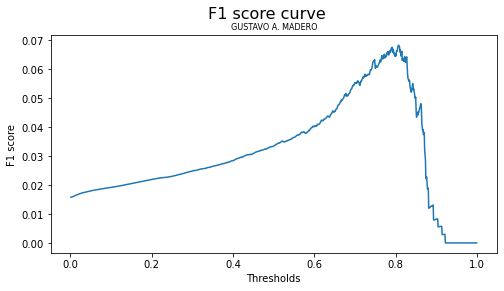

Results of Balanced Random Forest:

   F1 Score: 0.0683111954459203
   Accuracy: 0.9764874895247216
   Balanced Accuracy: 0.5459384420601819
   Average Precision Score: 0.026514712968688046


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     82866
           1       0.05      0.11      0.07       664

    accuracy                           0.98     83530
   macro avg       0.52      0.55      0.53     83530
weighted avg       0.99      0.98      0.98     83530

***************************


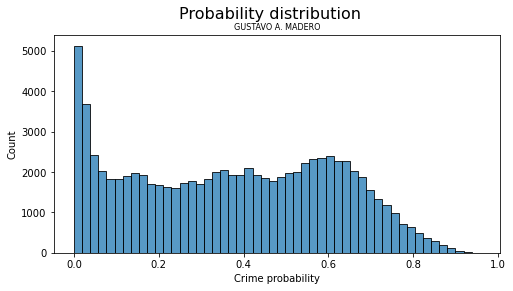

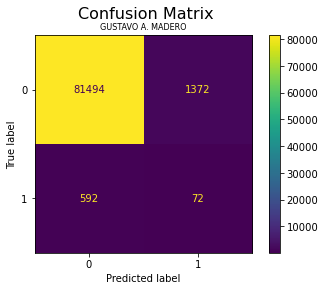

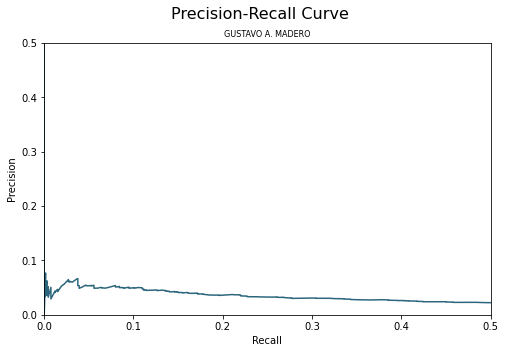

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|TLALPAN|


Total features:  44
Observations:  1281604


***TRAIN TABLE***
   Relative  Absolute
0   0.99284   1272428
1   0.00716      9176


***TEST TABLE***
   Relative  Absolute
0  0.994664     63382
1  0.005336       340
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: sqrt
   Threshold that max F1: 0.853



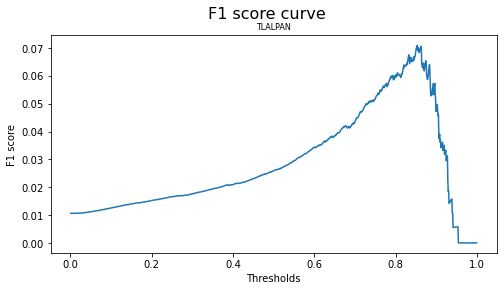

Results of Balanced Random Forest:

   F1 Score: 0.07097591888466413
   Accuracy: 0.9769938168921252
   Balanced Accuracy: 0.5730285273050244
   Average Precision Score: 0.025405929932392005


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     63382
           1       0.05      0.16      0.07       340

    accuracy                           0.98     63722
   macro avg       0.52      0.57      0.53     63722
weighted avg       0.99      0.98      0.98     63722

***************************


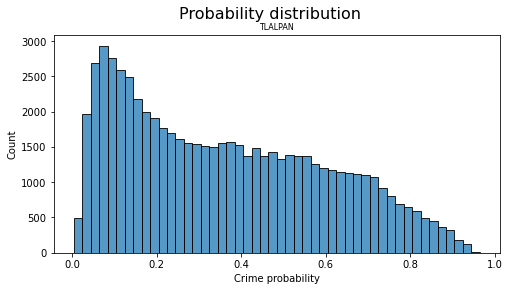

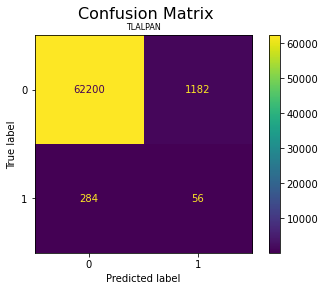

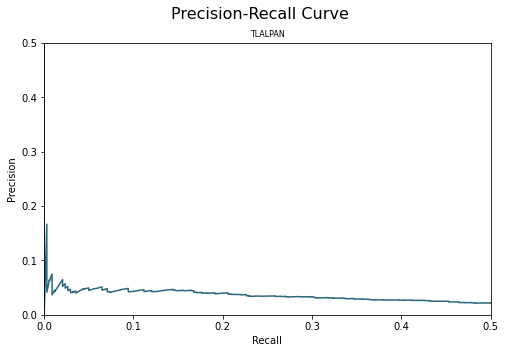

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|AZCAPOTZALCO|


Total features:  44
Observations:  803810


***TRAIN TABLE***
   Relative  Absolute
0  0.988329    794429
1  0.011671      9381


***TEST TABLE***
   Relative  Absolute
0  0.993119     39689
1  0.006881       275
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: sqrt
   Threshold that max F1: 0.78



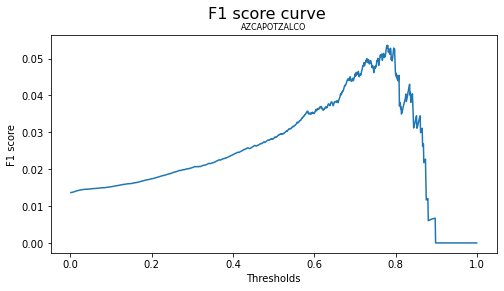

Results of Balanced Random Forest:

   F1 Score: 0.0536231884057971
   Accuracy: 0.9673205885296767
   Balanced Accuracy: 0.5538181176831685
   Average Precision Score: 0.020942010882781383


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     39689
           1       0.03      0.13      0.05       275

    accuracy                           0.97     39964
   macro avg       0.51      0.55      0.52     39964
weighted avg       0.99      0.97      0.98     39964

***************************


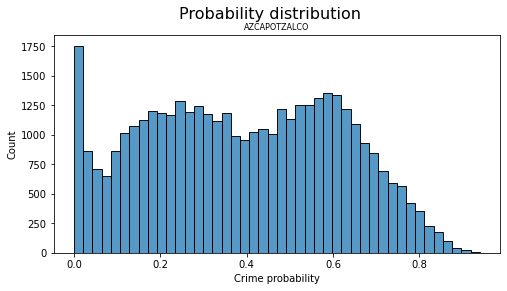

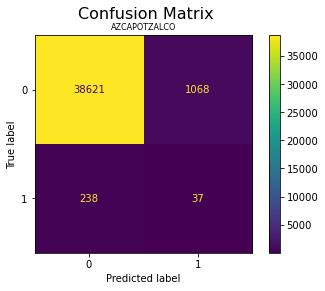

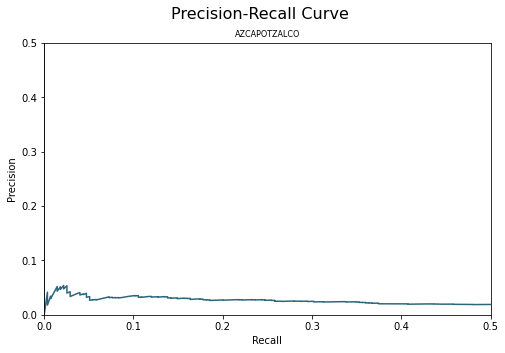

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|XOCHIMILCO|


Total features:  44
Observations:  572133


***TRAIN TABLE***
   Relative  Absolute
0  0.987859    565187
1  0.012141      6946


***TEST TABLE***
   Relative  Absolute
0  0.992617     28233
1  0.007383       210
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: sqrt
   Threshold that max F1: 0.882



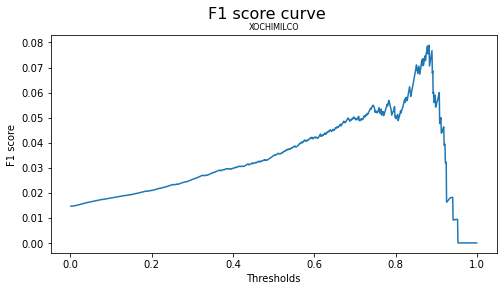

Results of Balanced Random Forest:

   F1 Score: 0.0788863109048724
   Accuracy: 0.9860422599585135
   Balanced Accuracy: 0.5368633969367154
   Average Precision Score: 0.03056776687139704


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     28233
           1       0.08      0.08      0.08       210

    accuracy                           0.99     28443
   macro avg       0.54      0.54      0.54     28443
weighted avg       0.99      0.99      0.99     28443

***************************


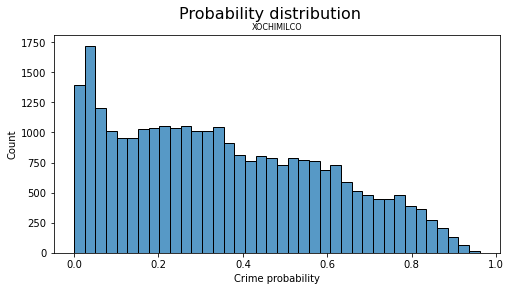

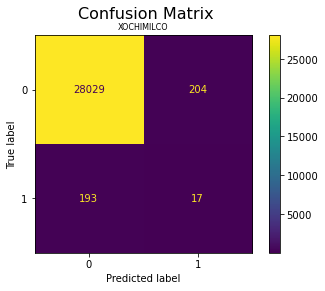

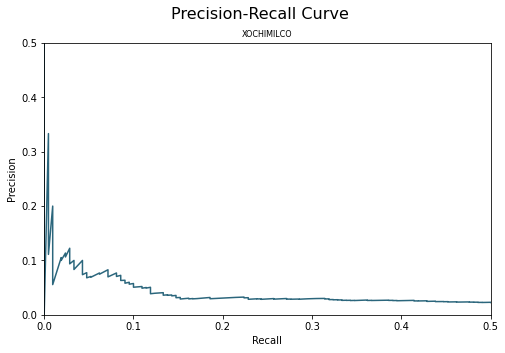

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|MILPA ALTA|


Total features:  44
Observations:  79656


***TRAIN TABLE***
   Relative  Absolute
0  0.989091     78787
1  0.010909       869


***TEST TABLE***
   Relative  Absolute
0  0.993687      3935
1  0.006313        25
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: sqrt
   Threshold that max F1: 0.857



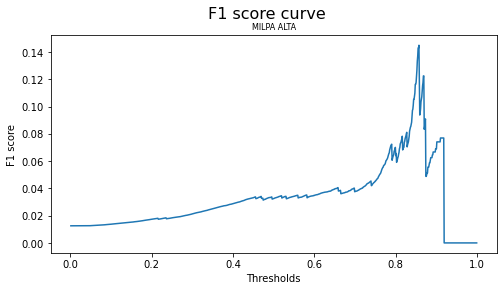

Results of Balanced Random Forest:

   F1 Score: 0.14492753623188406
   Accuracy: 0.9851010101010101
   Balanced Accuracy: 0.5950444726810673
   Average Precision Score: 0.07725225326729199


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3935
           1       0.11      0.20      0.14        25

    accuracy                           0.99      3960
   macro avg       0.55      0.60      0.57      3960
weighted avg       0.99      0.99      0.99      3960

***************************


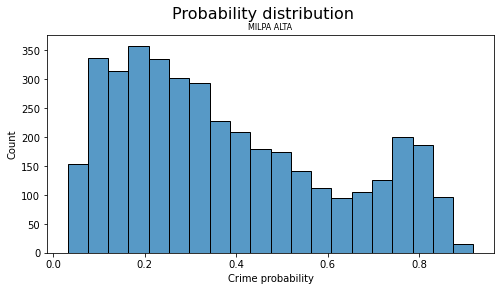

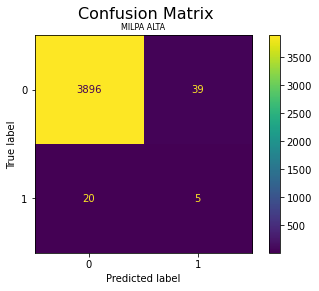

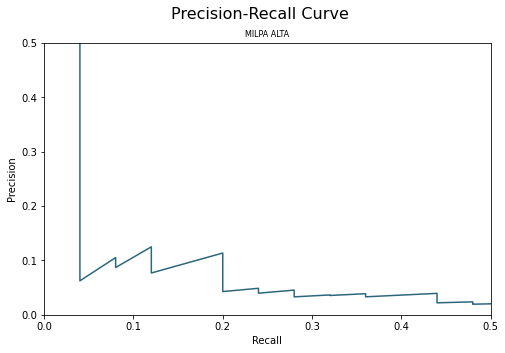

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|ALVARO OBREGON|


Total features:  44
Observations:  1810221


***TRAIN TABLE***
   Relative  Absolute
0    0.9931   1797730
1    0.0069     12491


***TEST TABLE***
   Relative  Absolute
0  0.995134     89568
1  0.004866       438
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: sqrt
   Threshold that max F1: 0.818



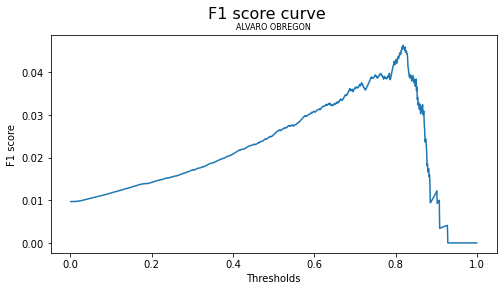

Results of Balanced Random Forest:

   F1 Score: 0.04631979695431472
   Accuracy: 0.9666022265182321
   Balanced Accuracy: 0.5685903447659879
   Average Precision Score: 0.016886906407310297


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     89568
           1       0.03      0.17      0.05       438

    accuracy                           0.97     90006
   macro avg       0.51      0.57      0.51     90006
weighted avg       0.99      0.97      0.98     90006

***************************


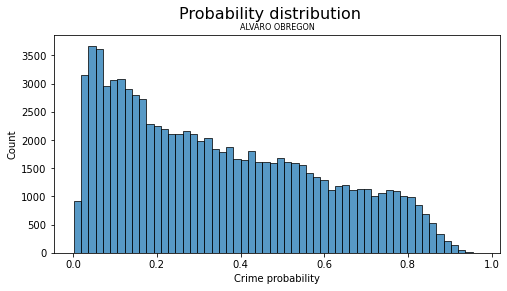

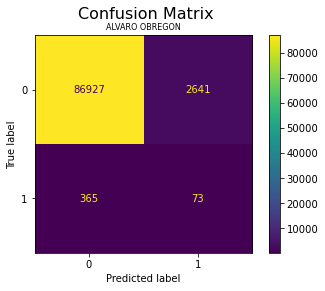

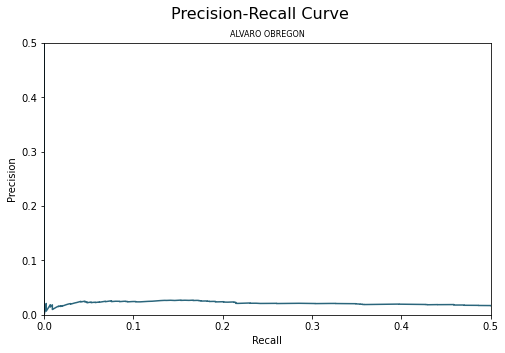

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|IZTACALCO|


Total features:  44
Observations:  398672


***TRAIN TABLE***
   Relative  Absolute
0  0.975456    388887
1  0.024544      9785


***TEST TABLE***
   Relative  Absolute
0  0.984094     19489
1  0.015906       315
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: sqrt
   Threshold that max F1: 0.748



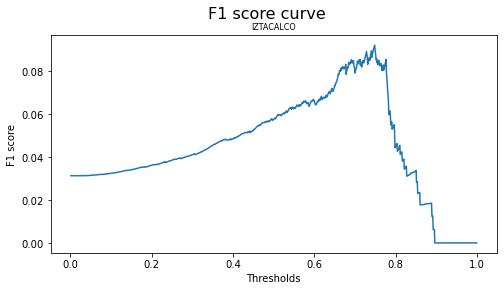

Results of Balanced Random Forest:

   F1 Score: 0.09215442092154422
   Accuracy: 0.963189254696021
   Balanced Accuracy: 0.5471595291442385
   Average Precision Score: 0.041891404071718


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     19489
           1       0.08      0.12      0.09       315

    accuracy                           0.96     19804
   macro avg       0.53      0.55      0.54     19804
weighted avg       0.97      0.96      0.97     19804

***************************


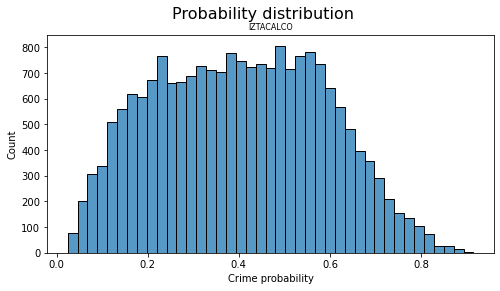

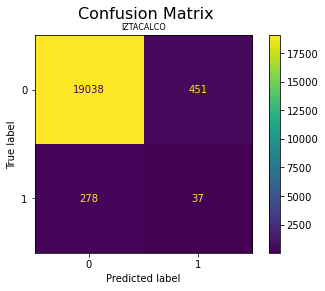

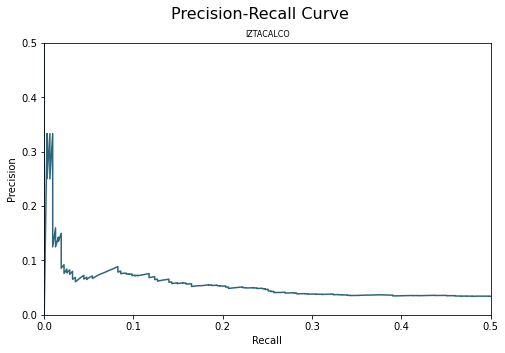

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|CUAUHTEMOC|


Total features:  44
Observations:  458607


***TRAIN TABLE***
   Relative  Absolute
0  0.946202    433935
1  0.053798     24672


***TEST TABLE***
   Relative  Absolute
0  0.973398     22101
1  0.026602       604
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: sqrt
   Threshold that max F1: 0.617



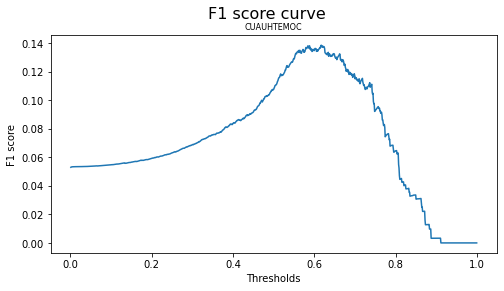

Results of Balanced Random Forest:

   F1 Score: 0.13846153846153847
   Accuracy: 0.9260074873375909
   Balanced Accuracy: 0.5843580165231803
   Average Precision Score: 0.07208034512596051


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.98      0.95      0.96     22101
           1       0.10      0.22      0.14       604

    accuracy                           0.93     22705
   macro avg       0.54      0.58      0.55     22705
weighted avg       0.95      0.93      0.94     22705

***************************


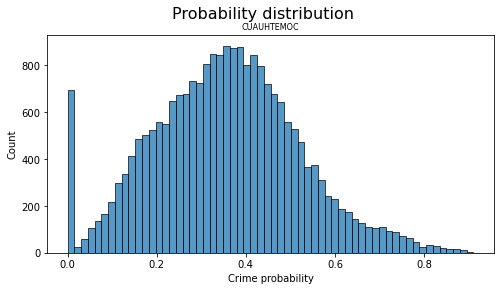

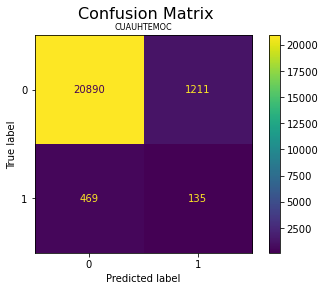

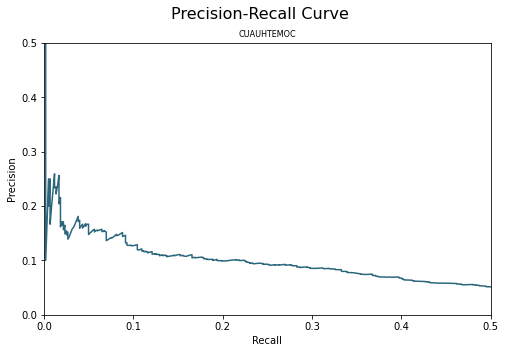

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|TLAHUAC|


Total features:  44
Observations:  420028


***TRAIN TABLE***
   Relative  Absolute
0  0.986708    414445
1  0.013292      5583


***TEST TABLE***
   Relative  Absolute
0   0.98918     20661
1   0.01082       226
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: sqrt
   Threshold that max F1: 0.769



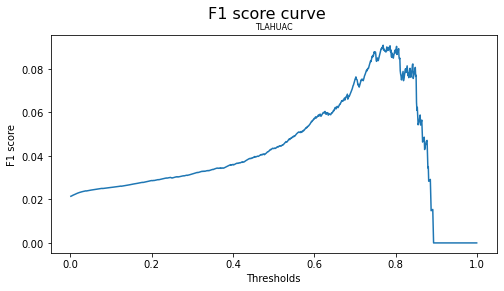

Results of Balanced Random Forest:

   F1 Score: 0.0909090909090909
   Accuracy: 0.9425479963613731
   Balanced Accuracy: 0.6077203726571331
   Average Precision Score: 0.03808542039619893


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     20661
           1       0.05      0.27      0.09       226

    accuracy                           0.94     20887
   macro avg       0.52      0.61      0.53     20887
weighted avg       0.98      0.94      0.96     20887

***************************


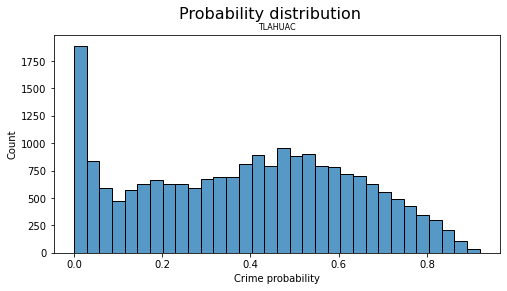

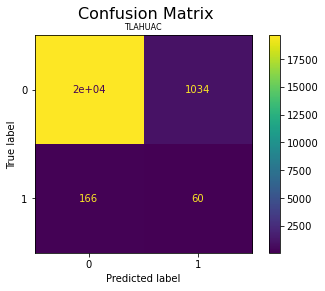

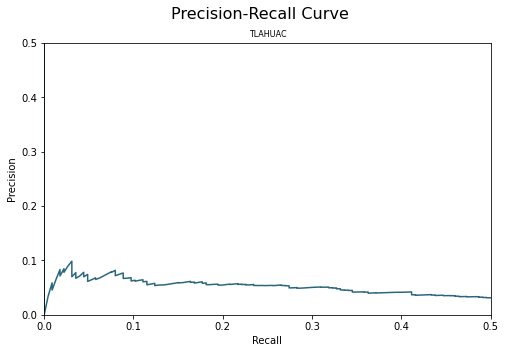

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|IZTAPALAPA|


Total features:  44
Observations:  2122273


***TRAIN TABLE***
   Relative  Absolute
0  0.982459   2085047
1  0.017541     37226


***TEST TABLE***
   Relative  Absolute
0  0.989052    104340
1  0.010948      1155
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: sqrt
   Threshold that max F1: 0.765



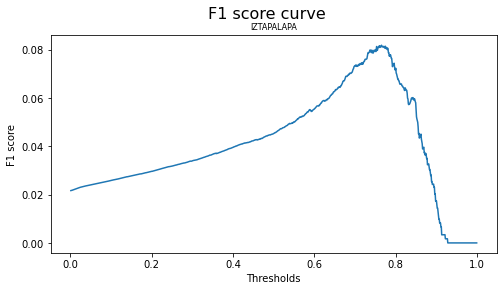

Results of Balanced Random Forest:

   F1 Score: 0.08188116733151375
   Accuracy: 0.9585477984738613
   Balanced Accuracy: 0.5680603994433782
   Average Precision Score: 0.035946052416754935


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.97      0.98    104340
           1       0.05      0.17      0.08      1155

    accuracy                           0.96    105495
   macro avg       0.52      0.57      0.53    105495
weighted avg       0.98      0.96      0.97    105495

***************************


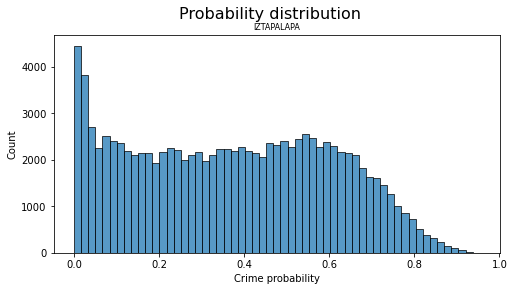

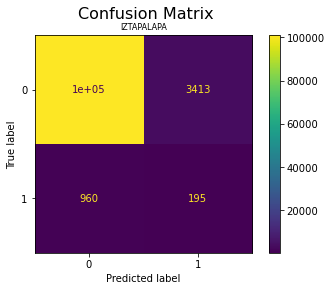

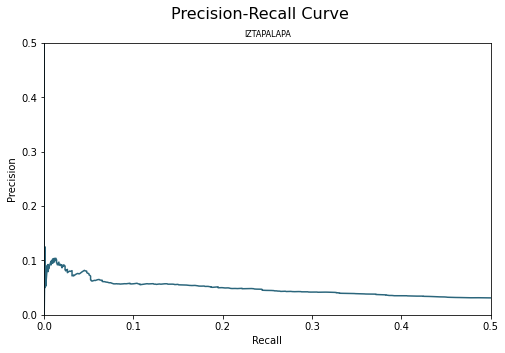

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
|CUAJIMALPA DE MORELOS|


Total features:  44
Observations:  311334


***TRAIN TABLE***
   Relative  Absolute
0  0.995789    310023
1  0.004211      1311


***TEST TABLE***
   Relative  Absolute
0  0.997481     15441
1  0.002519        39
----------------------------------------------------------------------------------------------------
Fitted Balanced Random Forest:

   Number of trees: 1000
   Max features: sqrt
   Threshold that max F1: 0.923



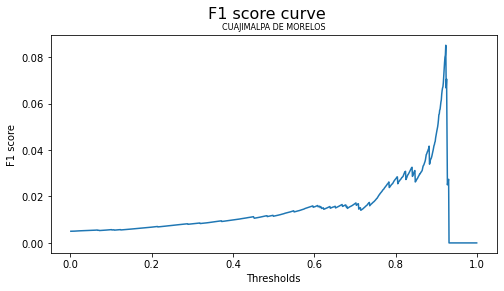

Results of Balanced Random Forest:

   F1 Score: 0.0851063829787234
   Accuracy: 0.9944444444444445
   Balanced Accuracy: 0.5496306038369376
   Average Precision Score: 0.01289427205567658


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15441
           1       0.07      0.10      0.09        39

    accuracy                           0.99     15480
   macro avg       0.54      0.55      0.54     15480
weighted avg       1.00      0.99      0.99     15480

***************************


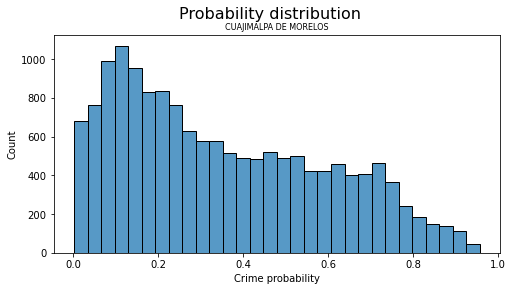

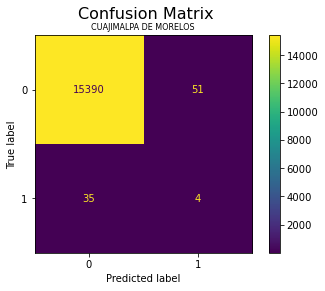

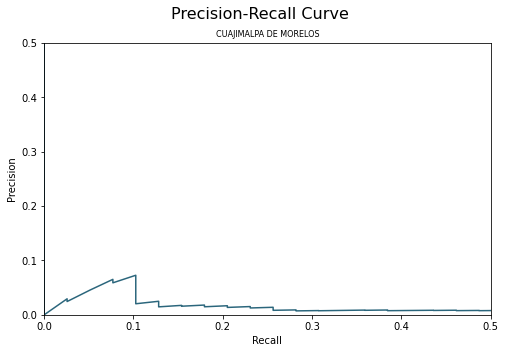

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------




In [9]:
## Loop for every Alcaldia (Municipality) and apply the model
alcaldias_list = colonias['alcaldi'].unique()

for alcaldia in alcaldias_list:
    
    ## Initialize the class model
    model = SplitTrainAndPredict(alcaldi=alcaldia, copy_df=matrix_crimes, colonias=colonias)

    ## Create tran-test splits
    X_train, X_test, y_train, y_test, save_columns, ind_test = model.train_test_df(col_dummies=False)

    ## Apply the model
    brf, predictions, crime_prob, threshold = model.fit_my_results(X_train, X_test, y_train, y_test)

    ## Show and save scores
    save_scores_df = model.show_my_results(y_test, crime_prob, predictions, threshold, brf, save_columns)

    ## Predict
    local_crimes_test = model.predict_crimes(X_test, ind_test, crime_prob, predictions, save_columns)

    ## Concat results
    results_brf = pd.concat([results_brf, local_crimes_test], ignore_index=True)
    all_scores = pd.concat([all_scores, save_scores_df], ignore_index=True)
    train_test_table = pd.concat([train_test_table, model.train_test_table], ignore_index=True)

In [10]:
if not os.path.isdir(create_path(r"df_results\BRF_non_dummies")):
    
    os.makedirs(create_path(r"df_results\BRF_non_dummies"))

## Save DataFrames results
results_brf.to_csv(create_path(r"df_results\BRF_non_dummies\results_brf.csv"), index=False)

all_scores.to_csv(create_path(r"df_results\BRF_non_dummies\all_scores.csv"), index=False)

train_test_table.to_csv(create_path(r"df_results\BRF_non_dummies\train_test_table.csv"), index=False)

## Finally, save a reduced form of the results DataFrame and Neighborhoods
reduced_results_brf = results_brf[['id_colonia', 'day_period', 'dia_semana', 'proba_crimen']]

reduced_results_brf.to_csv(create_path(r"df_results\BRF_non_dummies\reduced_results_brf.csv"), index=False)

reduced_colonias = colonias[['id_colonia', 'colonia', 'geometry']].copy()

reduced_colonias.to_csv(create_path(r"df_results\BRF_non_dummies\reduced_colonias.csv"), index=False)

In [11]:
results_brf = pd.read_csv(create_path(r"df_results\BRF_non_dummies\results_brf.csv"),low_memory=False,
                          parse_dates=['Hora'])

results_brf['geometry'] = gpd.GeoSeries.from_wkt(results_brf['geometry'])

results_brf = gpd.GeoDataFrame(results_brf, geometry='geometry')

Results of Balanced Random Forest:

   F1 Score: 0.0782905982905983
   Accuracy: 0.9669228327232072
   Balanced Accuracy: 0.5657244138722848
   Average Precision Score: 0.026120674395370694


      ***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.99      0.97      0.98    646225
           1       0.05      0.16      0.08      5826

    accuracy                           0.97    652051
   macro avg       0.52      0.57      0.53    652051
weighted avg       0.98      0.97      0.98    652051

***************************


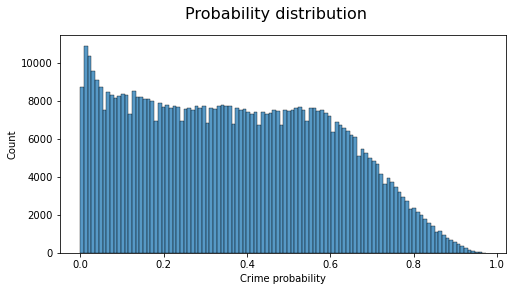

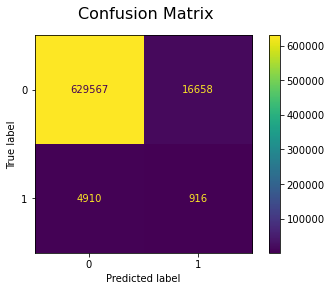

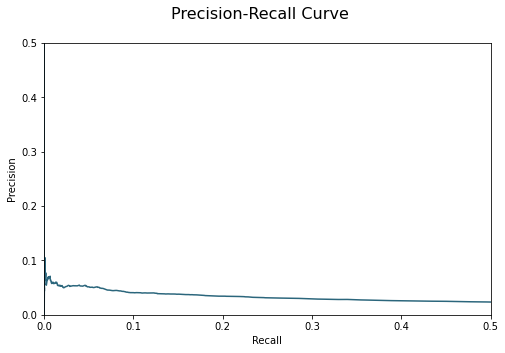

In [12]:
## Show aggregated results
model = SplitTrainAndPredict(copy_df=matrix_crimes, colonias=colonias, alcaldi="")


model.show_my_results(results_brf['crimen'], results_brf['proba_crimen'], results_brf['predictions'],
                      return_res_df=False)

### DBSCAN

We use DBSCAN to create clusters of crimes and hence reduce the spatial data. This will be help to have a better visual of the crime clusters locations. 

In [13]:
## Filter just crime observartions
crimes = matrix_crimes[matrix_crimes['crimen'] == 1].copy()

crimes['Coordinates'] = gpd.GeoSeries.from_wkt(crimes['Coordinates'])

crimes = gpd.GeoDataFrame(crimes, geometry='Coordinates')

## Create longitude and latitude series
crimes['lon'] = crimes['Coordinates'].apply(lambda p: p.x)
crimes['lat'] = crimes['Coordinates'].apply(lambda p: p.y)

## Filter just important columns
crimes = crimes[['lon','lat', 'categoria_delito']]

crimes['categoria_delito'].replace(crime_cat_dict,
                                   inplace=True)

In [14]:
## Transform to a numpyu array
coords = crimes[['lon','lat']].to_numpy()

## Establish epsilon to 50 meters
kms_per_radian = 6371.0088
epsilon = .05 / kms_per_radian

## Initiate DBSCAN
clt = DBSCAN(eps=epsilon, min_samples=50, algorithm='ball_tree', metric='haversine')

## Fit
model = clt.fit(np.radians(coords))

cluster_labels = model.labels_

crimes['cluster'] = cluster_labels

num_clusters = len(set(cluster_labels))
print('Number of clusters: {:,}'.format(num_clusters))

non_cluster = len(crimes[crimes['cluster'] == -1])
cluster_points = len(crimes[crimes['cluster'] != -1])

clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])

## Drop non clustered data points
crimes = crimes[crimes['cluster'] != -1]

print(f'Clustered points: {cluster_points}')
print(f'Non-Clustered points: {non_cluster}')

Number of clusters: 290
Clustered points: 55066
Non-Clustered points: 139084


In [15]:
## Save DataFram results
crimes.to_csv(create_path(r"df_results\BRF_non_dummies\cluster_crimes.csv"), index=False)

### Probability analysis

In [16]:
summary, results = rp.ttest(group1= results_brf['proba_crimen'][results_brf['crimen'] == 1], group1_name= "Crime",
                            group2= results_brf['proba_crimen'][results_brf['crimen'] == 0], group2_name= "Non-Crime")
print(summary)


    Variable         N      Mean        SD        SE  95% Conf.  Interval
0      Crime    5826.0  0.580357  0.187919  0.002462   0.575531  0.585184
1  Non-Crime  646225.0  0.367341  0.229602  0.000286   0.366781  0.367901
2   combined  652051.0  0.369244  0.230137  0.000285   0.368686  0.369803


In [17]:
print(results)

                  Independent t-test      results
0  Difference (Crime - Non-Crime) =        0.2130
1              Degrees of freedom =   652049.0000
2                               t =       70.6016
3           Two side test p value =        0.0000
4          Difference < 0 p value =        1.0000
5          Difference > 0 p value =        0.0000
6                       Cohen's d =        0.9291
7                       Hedge's g =        0.9291
8                   Glass's delta =        1.1336
9                     Pearson's r =        0.0871


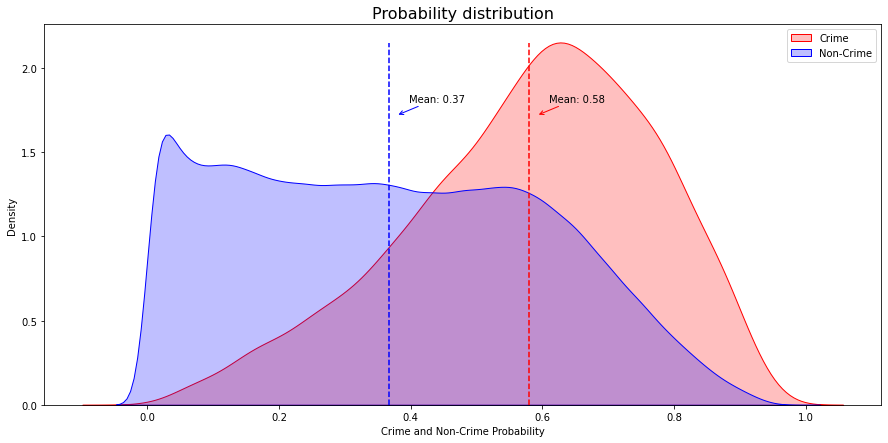

In [18]:
## Graficamos distribución kernel

fig = plt.figure(figsize=(15, 7))

ax = fig.subplots(1, 1)

a = sns.kdeplot(data=results_brf['proba_crimen'][results_brf['crimen'] == 1], shade=True, ax=ax,
               color='red')
b = sns.kdeplot(data=results_brf['proba_crimen'][results_brf['crimen'] == 0], shade=True, ax=ax,
               color='blue')       

plt.title('Probability distribution', fontdict={'fontsize': 16})

plt.xlabel('Crime and Non-Crime Probability')

plt.ylabel('Density')
plt.legend(labels=['Crime','Non-Crime'])

ax.axvline(x=results_brf['proba_crimen'][results_brf['crimen'] == 1].mean(), ymax=0.95, linestyle='--', color='red')
plt.annotate(
    'Mean: ' + '{:,.2f}'.format(results_brf['proba_crimen'][results_brf['crimen'] == 1].mean()),
    xy=(results_brf['proba_crimen'][results_brf['crimen'] == 1].mean(), 1.7),
    xytext=(results_brf['proba_crimen'][results_brf['crimen'] == 1].mean()+.03, 1.8),
    arrowprops=dict(arrowstyle='->', color='red', shrinkB=10))

ax.axvline(x=results_brf['proba_crimen'][results_brf['crimen'] == 0].mean(), ymax=0.95, linestyle='--', color='blue')

plt.annotate(
    'Mean: ' + '{:,.2f}'.format(results_brf['proba_crimen'][results_brf['crimen'] == 0].mean()),
    xy=(results_brf['proba_crimen'][results_brf['crimen'] == 0].mean(), 1.7),
    xytext=(results_brf['proba_crimen'][results_brf['crimen'] == 0].mean()+.03, 1.8),
    arrowprops=dict(arrowstyle='->', color='blue', shrinkB=10))

plt.show()

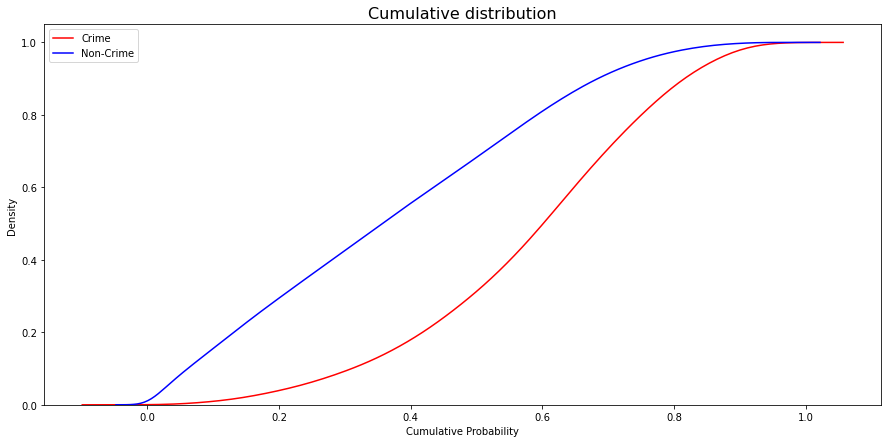

In [19]:
## Graficamos distribución kernel

fig = plt.figure(figsize=(15, 7))

ax = fig.subplots(1, 1)

a = sns.kdeplot(data=results_brf['proba_crimen'][results_brf['crimen'] == 1], ax=ax,
               color='red', cumulative=True)
b = sns.kdeplot(data=results_brf['proba_crimen'][results_brf['crimen'] == 0], ax=ax,
               color='blue', cumulative=True)       

plt.title('Cumulative distribution', fontdict={'fontsize': 16})

plt.xlabel('Cumulative Probability')

plt.ylabel('Density')
plt.legend(labels=['Crime','Non-Crime'])

plt.show()

In [20]:
results_brf_agg = results_brf.groupby(['id_colonia', 'colonia']).agg({'proba_crimen':['mean', 'median', 'std'], 
                                                                      'predictions':'mean',
                                                                      'crimen':'mean'}).reset_index()

results_brf_agg.columns = ['_'.join(col).strip() for col in results_brf_agg.columns.values]


In [21]:
results_brf_agg.sort_values(by='proba_crimen_mean', ascending=False).head(10)

,id_colonia_,colonia_,proba_crimen_mean,proba_crimen_median,proba_crimen_std,predictions_mean,crimen_mean
725,726,SAN PEDRO CUAJIMALPA (PBLO),0.875542,0.8825,0.044601,0.152778,0.016667
215,216,PASEOS DE CHURUBUSCO,0.865393,0.8770,0.046120,0.961219,0.096953
659,660,TLALPAN CENTRO,0.865302,0.8850,0.062759,0.689751,0.038781
173,174,SAN MIGUEL TOPILEJO (PBLO),0.863900,0.8715,0.046939,0.644444,0.055556
757,758,SANTIAGO TULYEHUALCO (PBLO),0.861659,0.8660,0.048918,0.379501,0.052632
584,585,SAN JERONIMO ACULCO - LIDICE (PBLO),0.858400,0.8630,0.048714,0.941667,0.030556
1790,1794,CAMPESTRE CHURUBUSCO,0.849383,0.8830,0.079626,0.647222,0.038889
33,34,SAN PEDRO MARTIR (PBLO),0.846556,0.8500,0.050669,0.483333,0.033333
201,202,JARDINES DEL PEDREGAL,0.846330,0.8670,0.074824,0.720222,0.033241
496,497,DEL CARMEN,0.844291,0.8730,0.086846,0.601108,0.047091


In [22]:
results_brf.reset_index(level=0, inplace=True, drop=True)

results_brf_recall = results_brf[results_brf['crimen'] == 1].copy()

results_brf_recall = results_brf_recall.groupby(results_brf['Hora'].dt.date)[['predictions']].mean().reset_index()

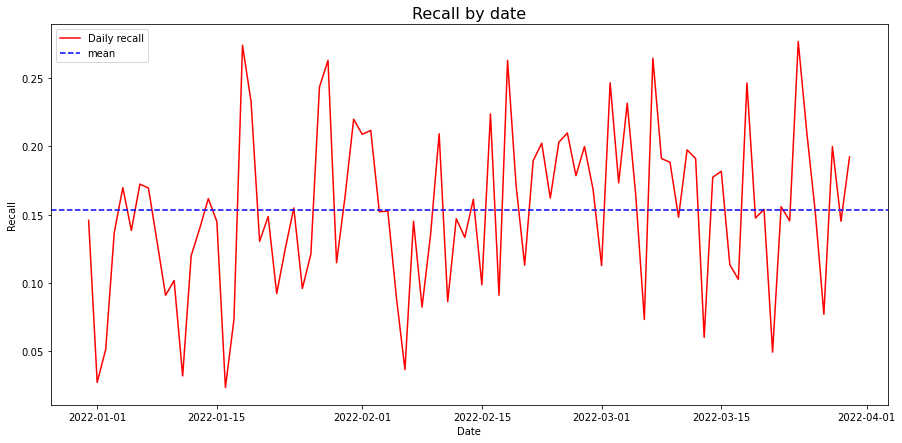

In [23]:
## Graficamos distribución kernel

fig = plt.figure(figsize=(15, 7))

ax = fig.subplots(1, 1)

a = sns.lineplot(data=results_brf_recall, y='predictions', x='Hora', ax=ax,
               color='red')

plt.title('Recall by date', fontdict={'fontsize': 16})

plt.xlabel('Date')

ax.axhline(y=results_brf_recall['predictions'].mean(), linestyle='--', color='blue')

plt.ylabel('Recall')
plt.legend(labels=['Daily recall', 'mean'])

plt.show()

In [24]:
results_brf_recall.groupby(results_brf['Hora'].dt.weekday)[['predictions']].mean().reset_index()

,Hora,predictions
0,0,0.155843
1,1,0.146086
2,2,0.148760
3,3,0.166696
4,4,0.157423
5,5,0.176968
6,6,0.116731


In [25]:
#https://www.analyticsvidhya.com/blog/2019/11/shapley-value-machine-learning-interpretability-game-theory/

#https://www.kaggle.com/prashant111/explain-your-model-predictions-with-shapley-values

#https://towardsdatascience.com/tagged/shapley-values

#https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html